# Carbon intensity cap models

Load packages, load data

In [66]:
import numpy as np
from scipy.optimize import curve_fit, minimize
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from cmocean import cm as cmo
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

In [2]:
flights = pd.read_csv("../data/by_route_airline.csv")
flights

,departure,arrival,arrival_longitude,arrival_latitude,departure_longitude,departure_latitude,airlinename,aircraft_types,avg_distance,flown_distance,gcd,flights,passengers,seats,average_load,co2,gco2_pax_km
0,SGN,HAN,105.806999,21.221201,106.652000,10.818800,Vietnam Airlines,5,1261.547796,1.154569e+07,1.063049e+07,9152,1.993998e+06,2447017,0.814869,191365.676340,76.944016
1,HAN,SGN,106.652000,10.818800,105.806999,21.221201,Vietnam Airlines,5,1261.547796,1.092879e+07,1.006249e+07,8663,1.966054e+06,2412725,0.814869,195266.817616,79.051205
2,CJU,GMP,126.791000,37.558300,126.492546,33.512058,Asiana Airlines,5,501.253150,5.223058e+06,4.702058e+06,10420,1.782774e+06,2123733,0.839453,100145.929946,110.904076
3,GMP,CJU,126.492546,33.512058,126.791000,37.558300,Asiana Airlines,5,501.253150,5.105765e+06,4.596465e+06,10186,1.719632e+06,2048514,0.839453,96146.969851,110.549887
4,FUK,HND,139.779999,35.552299,130.451004,33.585899,All Nippon Airways,9,982.357327,8.414873e+06,7.558273e+06,8566,1.708145e+06,2438270,0.700556,161111.234068,98.852367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81839,BOO,OSL,11.100400,60.193901,14.365300,67.269203,Wideroe's Flyveselskap,1,903.632067,9.036321e+02,8.036321e+02,1,2.521278e+01,39,0.646481,3.184374,139.769276
81840,DRW,TCA,134.182999,-19.634399,130.881851,-12.414970,Airnorth Regional,1,977.769135,9.777691e+02,8.777691e+02,1,2.355192e+01,30,0.785064,3.052329,132.546626
81841,TCA,DRW,130.881851,-12.414970,134.182999,-19.634399,Airnorth Regional,1,977.769135,9.777691e+02,8.777691e+02,1,2.355192e+01,30,0.785064,3.052329,132.546626
81842,TJN,PPT,-149.606995,-17.553699,-142.266464,-15.857434,Air Tahiti,1,905.066029,9.050660e+02,8.050660e+02,1,2.111117e+01,30,0.703706,2.493229,130.487717


Shuffle flights for plotting

In [3]:

sample = range(len(flights))                            # all flights or subsample to test?
sample_random = np.random.shuffle(np.copy(sample))      # randomize the order for plotting

In [265]:
average_load = np.array(flights["average_load"])[sample_random][0, :]
intensity = np.array(flights["gco2_pax_km"])[sample_random][0, :]
distance = np.array(flights["avg_distance"])[sample_random][0, :]
distance

array([1261.5477957 , 1261.5477957 ,  501.25315048, ...,  977.76913522,
        905.06602941, 4130.30219422], shape=(81844,))

Histogram of flight distances for legend

In [54]:
nbins = 10
m0, m1 = distance.min(), distance.max()     # choose min and max from data
m0, m1 = 100, 16000                         # or simplify for nicer bin edges
bin_edges = np.logspace(np.log10(m0), np.log10(m1), nbins + 1)
counts, _ = np.histogram(distance, bins=bin_edges)
counts = counts / np.sum(counts) * 100  # normalize to percent
counts

array([ 0.50270925,  2.19675379,  6.38599753, 10.86879411, 22.76624632,
       27.98659442, 18.51584574,  5.85637927,  3.98131047,  0.93936911])

# Carbon intensity cap models

We want to quantify how much lower the emissions from global aviation are if some/many flight connections would operate at a higher efficiency / lower carbon intensity, e.g. by setting a cap to 90gCO2/pax/km, essentially lower emissions from the inefficient flights.

I looked at the predictors of carbon intensity and I'm proposing another method. The reason is that both average load and flight distance are good predictors for carbon intensity, if there's more people on a plane the intensity is lower and if the plane flies for longer, it's a bigger plane, it flies higher (less resistance) and it travels further for one takeoff. Assuming that a small island hopper can operate at the same efficiency as a full A380 going from London to Singapore is somewhat unrealistic.

The blue dots in the figure below are essentially the flight connections we want to -- in this scenario -- improve in terms of efficiency. In practice this could be through some policies or business incentives. But how to we cap their carbon intensity? Instead of applying a straight line and clipping them all, I'm proposing something slightly more advanced, denoted here as a "carbon intensity cap model" with three levels "low" (little carbon savings by increasing the efficiencies only of the worst flight connections / airlines), "medium" (applying a somewhat higher standard, approximately representative of the industry mean) and "high" (applying the highest standard of efficencies that current airlines operate under to all flight connections). So this carbon intensity cap model would be

$$
\text{carbon intensity}(\text{load}, \text{distance}) = \frac{a}{\text{load} + l_0} + \frac{b}{\text{distance} + d_0}
$$

with both predictors in the denominator as twice the number of passengers approximately halfs the intensity in theory, and because longer flights can be more efficient due to reasons above. So both are inversly proportional but I decided to keep the model linear, hence both terms are simply added. Using least-squares optimization we estimate the constants to

- $a = 50$ gCO2/pax/km, which can be regarded here as the (on average across the industry) theoretical lower limit to intensity, (the actual minimum is 30 across the dataset)
- $l_0 = 0.01$ an offset load added so that the first term does not go to infinity in the limit of the load being 0. For O(100) people on a plane, this means always one person is on board at least.
- $b = 35,000$ gCO2/pax, the scaling for flight distance
- $d_0 = 200$ km an offset for flight distance, limiting the carbon intensity for shorter flights

Now this is the _carbon intensity medium cap_ model shown in orange in the figure. Due to the least-squares fit this corresponds to an industry average. We now define the _high_ cap model as 2/3s (-33.3%) of that intensity, i.e. a higher efficiency of aviation, and the _low_ cap model as 4/3s (+33.3%), a lower efficiency cap.

$$
\begin{align}
\text{carbon intensity (high cap)} &= \frac{4}{3} ~\text{carbon intensity (med cap)} \\
\text{carbon intensity (low cap)} &= \frac{2}{3} ~\text{carbon intensity (med cap)}
\end{align}
$$

In code this is simply

In [321]:
def carbon_cap_med(distance, load, a=40, b=20_000, l0=0.01, d0=100):
    return a/(load + 0.01) + b/(distance + d0)

def carbon_cap_low(distance, load, **kwargs):
    return 4/3*carbon_cap_med(distance, load, **kwargs)

def carbon_cap_high(distance, load, **kwargs):
    return 2/3*carbon_cap_med(distance, load, **kwargs)

# Least squares fit to calibrate a, b, d0 (l0 is fixed)

In [ ]:
# function to optimize, put both independent variables into a tuple X
def f(X, a, b, l0, d0):
    distance, load = X
    return carbon_cap_med(distance, load, a=a, b=b, l0=l0, d0=d0)

# loss function to minimize
def loss(params, X, y):
    a, b, l0, d0 = params
    return np.sum((y - f(X, a, b, l0, d0))**2)          # least squares
    # return np.sum(np.abs(y - f(X, a, b, l0, d0)))     # other loss functions
    # return np.median((y - f(X, a, b, l0, d0))**2)

In [323]:
# OPTIMIZATION WITH NELDER-MEAD, general loss function
p0 = [1, 100*np.random.rand(), np.random.rand(), 100]
result = minimize(loss, p0, args=((distance, average_load), intensity/1000), method="Nelder-Mead", options={'maxiter': 2000})
popt_scaled = result.x
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 46.68731484446748
             x: [ 5.448e-02  3.562e+01  2.191e-01  1.829e+02]
           nit: 225
          nfev: 394
 final_simplex: (array([[ 5.448e-02,  3.562e+01,  2.191e-01,  1.829e+02],
                       [ 5.448e-02,  3.562e+01,  2.191e-01,  1.829e+02],
                       ...,
                       [ 5.448e-02,  3.562e+01,  2.191e-01,  1.829e+02],
                       [ 5.448e-02,  3.562e+01,  2.191e-01,  1.829e+02]],
                      shape=(5, 4)), array([ 4.669e+01,  4.669e+01,  4.669e+01,  4.669e+01,
                        4.669e+01]))

### Optimal parameters

In [312]:
popt = [popt_scaled[0]*1000, popt_scaled[1]*1000, popt_scaled[2], popt_scaled[3]]
for p, v in zip(('a', 'b', 'l0', 'd0'), popt2):
    print(f"{p}: {v:.2f}")

a: 54.48
b: 35621.61
l0: 0.87
d0: 182.91


### Simplified optimal parameters

In [313]:
popts = [50, 35_000, 0.01, 200]  # simplified optimal values

# Plotting

/var/folders/rq/g428p_c576b5x1xzwsc9gfv80000gp/T/ipykernel_25423/3182424658.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


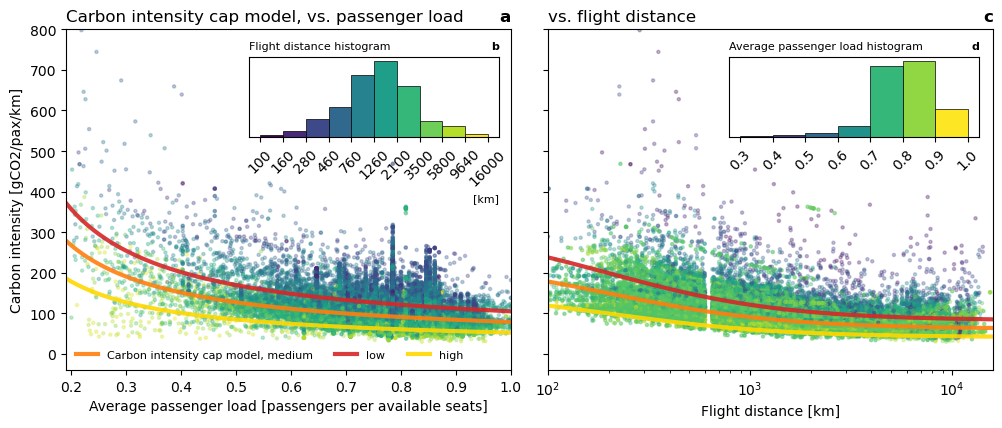

In [325]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), sharey=True)
axh1 = fig.add_axes([0.23, 0.68, 0.25, 0.2])     # histogram axes
axh2 = fig.add_axes([0.71, 0.68, 0.25, 0.2])     # histogram axes
plt.tight_layout()

# left subplot
ax1.scatter(average_load, intensity, 5, c=np.log(distance), alpha=.3, cmap="viridis")
ax1.set_xlabel("Average passenger load [passengers per available seats]")
ax1.set_ylabel("Carbon intensity [gCO2/pax/km]")

ax1.set_xlim(0.19, 1)
ax1.set_ylim(-40, 800)
ax1.set_title("a", loc="right", fontweight="bold")
ax1.set_title("Carbon intensity cap model, vs. passenger load", loc="left")

# add carbon intensity cap model
load = np.linspace(0.01, 1, 100)
base_distance = 1000
ax1.plot(load, carbon_cap_med(base_distance, load, a=popts[0], b=popts[1], l0=popts[2], d0=popts[3]), color="C1",    lw=3, alpha=0.9, label="Carbon intensity cap model, medium")
ax1.plot(load, carbon_cap_low(base_distance, load, a=popts[0], b=popts[1], l0=popts[2], d0=popts[3]), color="C3",    lw=3, alpha=0.9, label="low")
ax1.plot(load, carbon_cap_high(base_distance, load, a=popts[0], b=popts[1], l0=popts[2], d0=popts[3]), color="gold", lw=3, alpha=0.9, label="high")
ax1.legend(loc="lower left", fontsize=8, frameon=False, ncols=3)


# histogram colorbar
bins = np.arange(1, len(counts) + 1)
cmap = plt.get_cmap("viridis")
axh1.bar(bins, counts, width=1, color=cmap((bins-1)/(len(bins)-1)), edgecolor="k", linewidth=0.5)
axh1.set_xticks(np.arange(0, len(counts) + 1)+.5)
axh1.set_xticklabels(np.round(bin_edges/20).astype(int)*20, rotation=45)
axh1.set_title("Flight distance histogram", loc="left", fontsize=8)
axh1.set_title("b", loc="right", fontweight="bold", fontsize=8)
axh1.set_xlabel("[km]", loc="right", fontsize=8)
axh1.get_yaxis().set_visible(False)

# right subplot
ax2.scatter(distance, intensity, 5, c=average_load, alpha=.3, cmap="viridis")
ax2.set_xlabel("Flight distance [km]")
ax2.set_xscale("log")
ax2.set_xlim(m0, m1)
ax2.set_title("c", loc="right", fontweight="bold")
ax2.set_title("vs. flight distance", loc="left")

# add carbon intensity cap model
dists = np.logspace(np.log10(m0), np.log10(m1), 100)
base_load = 0.8
ax2.plot(dists, carbon_cap_med(dists, base_load, a=popts[0], b=popts[1], l0=popts[2], d0=popts[3]), color="C1",    lw=3, alpha=0.9)
ax2.plot(dists, carbon_cap_low(dists, base_load, a=popts[0], b=popts[1], l0=popts[2], d0=popts[3]), color="C3",    lw=3, alpha=0.9)
ax2.plot(dists, carbon_cap_high(dists, base_load, a=popts[0], b=popts[1], l0=popts[2], d0=popts[3]), color="gold", lw=3, alpha=0.9)

# histogram colorbar
counts2, bin_edges2 = np.histogram(average_load, bins=np.linspace(0.3, 1, 8))
bins = np.arange(1, len(counts2) + 1)
cmap = plt.get_cmap("viridis")
axh2.bar(bins, counts2, width=1, color=cmap((bins-1)/(len(bins)-1)), edgecolor="k", linewidth=0.5)
axh2.set_xticks(np.arange(0, len(counts2) + 1)+.5)
axh2.set_xticklabels(np.round(bin_edges2*10)/10, rotation=45)
axh2.set_title("Average passenger load histogram", loc="left", fontsize=8)
axh2.set_title("d", loc="right", fontweight="bold", fontsize=8)
axh2.get_yaxis().set_visible(False)

plt.show()

Fig ?: Carbon intensity of flight connections as a function of (a) average passenger load and (c) flight distance (detours, holding included). Each marker denotes one flight connection between two airports. They are colour-coded with flight distance in (a) and passenger load in (c). The colourbar is visualised as a histogram in (b, d) respectively for (a, c). Note that (b, c) show flight distance on a logarithmic axis. A carbon intensity cap model (red, orange, yellow lines) is added as a simple model to represent an approximate industry standard of low, medium and high carbon efficiency (inverse of carbon intensity) for civil aviation. The medium models is a least-squares fit, representing an industry average, the low model has a 33% lower efficiency, the high model a 33% higher one.